# More Advanced  Optimization for Machine Learning
From previous notebooks, we know that the logistic regression update equation is given by:
$$ \underbrace{w_j}_{\text{new value}} \leftarrow \underbrace{w_j}_{\text{old value}} + \eta \underbrace{\sum_{i=1}^M (y^{(i)}-\hat{y}^{(i)})x^{(i)}_j}_{\text{gradient}} $$

$$ w \leftarrow w + \eta \sum_{i=1}^M (y^{(i)}-\hat{y}^{(i)})x^{(i)} $$

Which can be made more generic by denoting the objective function as $l(w)$:
$$ w \leftarrow w + \eta \nabla l(w)$$

One problem is that we still need to set the value of $\eta$, which can drastically change the performance of the optimization algorithm. If $\eta$ is too large, the algorithm might be unstable. If $\eta$ is too small, it might take forever to converge.
$$ w \leftarrow w + \underbrace{\eta}_{\text{best step?}} \nabla l(w) $$

We can solve this issue by performing a line search for the best value of $\eta$ along the direction of the gradient, as denoted by:

$$ \eta \leftarrow \arg\min_\eta \sum_{i=1}^M (y^{(i)}-\hat{y}^{(i)})^2 $$

# Optimizing Logistic Regression via Line Search

In [1]:
from sklearn.datasets import load_iris
import numpy as np

ds = load_iris()
X = ds.data
y = (ds.target>1).astype(np.int) # make problem binary
Xb = np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

def accuracy(y,yhat):
    return sum(yhat==y)/len(y)

In [2]:
# from last time, our logistic regression algorithm is given by:
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    def sigmoid(self,theta):
        return 1/(1+np.exp(-theta))
    
    def predict_proba(self,X):
        return self.sigmoid(X @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5).astype(np.int).ravel() #return the actual prediction
    
    # vectorized the fit function
    def fit(self, X, y):
        num_samples, num_features = X.shape    
        
        self.w_ = np.zeros((num_features,1))
        for _ in range(self.iters):
            ydiff = y-self.predict_proba(X).ravel() # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            self.w_ += gradient.reshape(self.w_.shape)*self.eta # add with learning rate
        

blr = BinaryLogisticRegression(0.1,500)

%time blr.fit(Xb,y)
print(blr)

yhat = blr.predict(Xb)
print('Accuracy of: ',accuracy(y,yhat))

CPU times: user 36.7 ms, sys: 2.68 ms, total: 39.4 ms
Wall time: 39.6 ms
Binary Logistic Regression Object with coefficients:
[[ -58.04278718]
 [-101.88713425]
 [ -89.9532887 ]
 [ 149.56437443]
 [ 128.26409526]]
Accuracy of:  0.98


/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp


In [3]:
# and we can update this to use a line search along the gradient like this:
from scipy.optimize import minimize_scalar
import copy
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    def fit(self, X, y):
        num_samples, num_features = X.shape
        
        # define custom line search for problem
        def line_search_function(eta,X,y,w,grad):
            wnew = w+grad*eta
            yhat = (1/(1+np.exp(-X @ wnew)))>0.5
            return np.sum((y-yhat)**2)
        
        
        self.w_ = np.zeros((num_features,1))
        for _ in range(self.iters):
            # get gradient direction
            ydiff = y-self.predict_proba(X).ravel() # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/20} # unclear exactly what this should be
            res = minimize_scalar(line_search_function, # objective function to optimize
                                  bounds=(self.eta/10,self.eta*10), #bounds to optimize
                                  args=(X,y,self.w_,gradient), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            eta = res.x # get optimal learning rate
            self.w_ += gradient*eta # set new function values
                
            

lslr = LineSearchLogisticRegression(0.1,60)

%time lslr.fit(Xb,y)

yhat = lslr.predict(Xb)
print(lslr)
print('Accuracy of: ',accuracy(y,yhat))         

CPU times: user 41.1 ms, sys: 2.25 ms, total: 43.3 ms
Wall time: 43.8 ms
Binary Logistic Regression Object with coefficients:
[[-103.5757535 ]
 [-227.88065221]
 [-249.2494365 ]
 [ 380.44490565]
 [ 274.40859102]]
Accuracy of:  0.966666666667


/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: overflow encountered in exp
/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: overflow encountered in exp


This is an improvement in the accuracy, but did take a little while longer (this is because $\eta$ was chosen well in the initial example). 
___

# Stochastic Gradient Descent
Sometimes the gradient calcualtion is too computational:
$$ w \leftarrow w + \eta \sum_{i=1}^M (y^{(i)}-\hat{y}^{(i)})x^{(i)} $$

Instead, we can approximate the gradient using one instance, this is called stochastic gradient descent (SGD) because the steps can appear somewhat random.
$$ w \leftarrow w + \eta \underbrace{(y^{(i)}-\hat{y}^{(i)})x^{(i)}}_{\text{approx. gradient}} \text{,   where   } i\in M$$

Let's code up the SGD example.

In [4]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    def fit(self, X, y):
        num_samples, num_features = X.shape    
        
        self.w_ = np.zeros((num_features,1))
        for _ in range(self.iters):
            idx = int(np.random.rand()*len(y)) # grab random instance
            ydiff = y[idx]-self.predict_proba(X[idx]) # get y difference
            gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
            self.w_ += gradient.reshape(self.w_.shape)*self.eta # add with learning rate
        
slr = StochasticLogisticRegression(0.1,1000)

%time slr.fit(Xb,y)

yhat = slr.predict(Xb)
print(slr)
print('Accuracy of: ',accuracy(y,yhat))      

CPU times: user 22.4 ms, sys: 3.53 ms, total: 25.9 ms
Wall time: 26.6 ms
Binary Logistic Regression Object with coefficients:
[[-1.55739978]
 [-2.86353535]
 [-3.15928981]
 [ 4.41201547]
 [ 4.16543722]]
Accuracy of:  0.98


___
# Optimizing with Second Order Derivatives
First, let's look at the one dimensioanl case when we have a function $l(w)$ where w is a scalar. The optimal value of w is given by:

$$ w \leftarrow w - \underbrace{[\frac{\partial^2}{\partial w}l(w)]^{-1}}_{\text{inverse 2nd deriv}}\underbrace{\frac{\partial}{\partial w}l(w)}_{\text{derivative}}  $$

Note that if $l(w)$ is a quadrativ function, this solution converges in a single step!


### Aside: an example with the second derivative:
Say $l(w)=2w^2+4w+5$, and we want to minimize the function. We have that:

$\frac{\partial}{\partial w}l(w)=4w+4$

and 

$\frac{\partial^2}{\partial w}l(w)=4$. 

Therefore, if we choose $w_{start}=0$, we have: 

$\frac{\partial}{\partial w}l(0)=4$ 

and 

$\frac{\partial^2}{\partial w}l(0)=4$ 

So the update becomes

$w \leftarrow w_{start} - \frac{1}{4}4 = -1$

The solution is found in one step. This works for any initial value of $w_{start}$. Let's verify that the solution worked graphically.

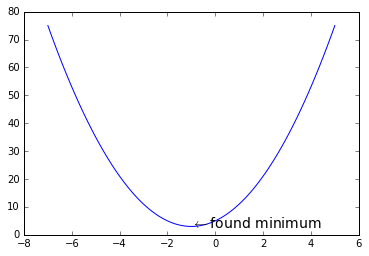

In [5]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

w = np.linspace(-7,5,100)
l = 2*w**2+4*w+5
plt.plot(w,l)
plt.text(-1,2.5,'$\leftarrow$found minimum',fontsize=14)

___
But how do we translate this over to objective funtions with more than one variable? We need a second derivative... enter, the hessian:

$$ \nabla^2 l(w) = \mathbf{H}[l(w)]   $$

$$  \mathbf{H}[l(w)] =  \begin{bmatrix}
        \frac{\partial^2}{\partial w_1}l(w) &  \frac{\partial}{\partial w_1}\frac{\partial}{\partial w_2}l(w) & \ldots     & \frac{\partial}{\partial w_1}\frac{\partial}{\partial w_N}l(w)  \\
        \frac{\partial}{\partial w_2}\frac{\partial}{\partial w_1}l(w)  & \frac{\partial^2}{\partial w_2}l(w) &  \ldots     & \frac{\partial}{\partial w_2}\frac{\partial}{\partial w_N}l(w)  \\
        &  \vdots &\\
        \frac{\partial}{\partial w_N}\frac{\partial}{\partial w_1}l(w)  & \frac{\partial}{\partial w_N}\frac{\partial}{\partial w_2}l(w) &  \ldots     & \frac{\partial^2}{\partial w_N}l(w) \\
     \end{bmatrix}
$$

$$ w \leftarrow w + \eta \cdot \underbrace{\mathbf{H}[l(w)]^{-1}}_{\text{inverse Hessian}}\cdot\underbrace{\nabla l(w)}_{\text{gradient}}$$

For logistic regression
$$ \mathbf{H}_{j,k}[l(w)] = -\sum_{i=1}^M g(x^{(i)})(1-g(x^{(i)}){x_k}^{(i)}{x_j}^{(i)}   $$

You can see the full derivation of the Hessian in my notes here:
- https://raw.githubusercontent.com/eclarson/MachineLearningNotebooks/master/PDF_Slides/HessianCalculation.pdf

$$ \mathbf{H}[l(w)] =  X^T \cdot \text{diag}[g(x^{(i)})(1-g(x^{(i)})]\cdot X $$

$$ w \leftarrow w + \eta [X^T \cdot \text{diag}[g(x^{(i)})(1-g(x^{(i)})]\cdot X]^{-1}\cdot X*y_{diff}$$

So let's code this up using numpy:

In [6]:
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite fit function
    def fit(self, X, y):
        num_samples, num_features = X.shape
        
        self.w_ = np.zeros((num_features,1))
        for _ in range(self.iters):
            g = self.predict_proba(X).ravel() # get sigmoid value for all classes
            hessian = X.T @ np.diag(g*(1-g)) @ X # calculate the hessian
            
            ydiff = y-g # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
            gradient = gradient.reshape(self.w_.shape)#/len(y)
            
            self.w_ += self.eta * np.linalg.pinv(hessian) @ gradient # add with learning rate
            
hlr = HessianBinaryLogisticRegression(1,5) # note that we need only a few iterations here

%time hlr.fit(Xb,y)
yhat = hlr.predict(Xb)
print(hlr)
print('Accuracy of: ',accuracy(y,yhat))

CPU times: user 7.23 ms, sys: 1.72 ms, total: 8.95 ms
Wall time: 5.35 ms
Binary Logistic Regression Object with coefficients:
[[-14.08319984]
 [ -1.59714009]
 [ -2.20181703]
 [  3.81731771]
 [  7.04317257]]
Accuracy of:  0.98


___
But, as we discussed, the hessian can sometimes be ill formed for these problems and can also be highly computational. Thus, we need to approximate the Hessain, and also use some heuristics (like momentum) to better control the steps we make and directions we use. 

We won't explicitly program the BFGS algorithm--instead we can take advantage of scipy's calculations to do it for us. 

### BFGS

In [7]:
# for this, we won't perform our own BFGS implementation (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite fit function
    def fit(self, X, y):
        num_samples, num_features = X.shape
        
        def objective_function(w,X,y):
            g = (1/(1+np.exp(-X @ w)))
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))
        
        def objective_gradient(w,X,y):
            g = (1/(1+np.exp(-X @ w)))
            yhat = g #(g>0.5).astype(np.int)
            ydiff = y-yhat # get y difference
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0)
            gradient = gradient.reshape(w.shape)/len(y)
            return -gradient
        
        self.w_ = fmin_bfgs(objective_function, 
                            np.zeros((num_features,1)), 
                            fprime=objective_gradient, 
                            args=(X,y),gtol=1e-03,
                            maxiter=self.iters,
                            disp=False).reshape((num_features,1))
            
bfgslr = BFGSBinaryLogisticRegression(0.1,2) # note that we need only a few iterations here

%time bfgslr.fit(Xb,y)
yhat = bfgslr.predict(Xb)
print(bfgslr)
print('Accuracy of: ',accuracy(y,yhat))

CPU times: user 8.02 ms, sys: 971 µs, total: 8.99 ms
Wall time: 6.44 ms
Binary Logistic Regression Object with coefficients:
[[-0.11114818]
 [-0.2677297 ]
 [-0.37792715]
 [ 0.49339159]
 [ 0.28635464]]
Accuracy of:  0.98


## BFGS for Multiclass Logistic Regression
Now let's add BFGS to non-binary classification. As before, we will use one-versus-all.

In [8]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = BFGSBinaryLogisticRegression(self.eta,self.iters)
            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    
ds = load_iris()
X = ds.data
y_not_binary = ds.target # note problem is NOT binary anymore, there are three classes!
Xb = np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

lr = MultiClassLogisticRegression(1,10)
%time lr.fit(Xb,y_not_binary)
print(lr)

yhat = lr.predict(Xb)
print('Accuracy of: ',accuracy(y_not_binary,yhat))


CPU times: user 11.9 ms, sys: 426 µs, total: 12.3 ms
Wall time: 6.83 ms
MultiClass Logistic Regression Object with coefficients:
[[ 0.52228397  0.94092592  2.81252107 -4.20625865 -1.90723814]
 [ 0.78427265  1.16013913 -2.66583412  0.56585043 -2.1566517 ]
 [-2.31059509 -5.09367038 -5.38233776  8.07959037  5.94573873]]
Accuracy of:  0.98


In [9]:
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='lbfgs',n_jobs=1) # all params default
# note that sklearn is optimized for using the liblinear library with logistic regression
# ...and its faster than our implementation here

%time lr_sk.fit(X,y_not_binary) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy(y_not_binary,yhat))

CPU times: user 28.2 ms, sys: 1.01 ms, total: 29.2 ms
Wall time: 17 ms
[[-0.44524582  0.89469401 -2.32542777 -0.97869151]
 [-0.18587061 -2.11489439  0.69770617 -1.25139648]
 [-0.39444575 -0.5132796   2.93082545  2.41710589]]
Accuracy of:  0.953333333333


In [10]:
# actually, we aren't nearly as good as the lib linear implementation
# how do we compare now to sklearn?
from sklearn.linear_model import LogisticRegression

lr_sk = LogisticRegression(solver='liblinear',n_jobs=1) 

%time lr_sk.fit(X,y_not_binary) # no need to add bias term, sklearn does it internally!!
print(lr_sk.coef_)
yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy(y_not_binary,yhat))

CPU times: user 3.27 ms, sys: 2.4 ms, total: 5.67 ms
Wall time: 4.48 ms
[[ 0.41498833  1.46129739 -2.26214118 -1.0290951 ]
 [ 0.41663969 -1.60083319  0.57765763 -1.38553843]
 [-1.70752515 -1.53426834  2.47097168  2.55538211]]
Accuracy of:  0.96


In [11]:
# its still faster! Can we fix that?
from joblib import Parallel, delayed

def par_logistic(yval,eta,iters,X,y):
    y_binary = y==yval # create a binary problem
    # train the binary classifier for this class
    hblr = BFGSBinaryLogisticRegression(eta,iters)
    hblr.fit(X,y_binary)
    return hblr

class ParallelMultiClassLogisticRegression(MultiClassLogisticRegression):
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        backend = 'threading' #'multiprocessing'
        self.classifiers_ = Parallel(n_jobs=1,backend=backend)(
            delayed(par_logistic)(yval,self.eta,self.iters,X,y) for yval in self.unique_)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
plr = ParallelMultiClassLogisticRegression(1,10)
%time plr.fit(Xb,y_not_binary)
print(plr)

yhat = plr.predict(Xb)
print('Accuracy of: ',accuracy(y_not_binary,yhat))

CPU times: user 15.6 ms, sys: 418 µs, total: 16 ms
Wall time: 8.59 ms
MultiClass Logistic Regression Object with coefficients:
[[ 0.52228397  0.94092592  2.81252107 -4.20625865 -1.90723814]
 [ 0.78427265  1.16013913 -2.66583412  0.56585043 -2.1566517 ]
 [-2.31059509 -5.09367038 -5.38233776  8.07959037  5.94573873]]
Accuracy of:  0.98


___
Please note that the overhead of parallelization is not worth it for this problem!!